# `RealSim-CFIS`

In this doc I build the functionality for a version of `RealSim` that specifically deals with the Canada-France Imaging Survey.

## Atmospheric attenuation analysis

### Starting with the SDSS filter response functions

Here I investigate the atmospheric affects on the SDSS filter response functions in preparation for implementation in the Realism suite and for application of findings to the CFIS image generation. I found where the "Doi and Annis" response curves were. They appear to be incorrect, as I had suspected. I suggest updating files to use the Doi et al (2010) filter response results found here: http://classic.sdss.org/dr7/instruments/imager/index.html#filters. 

In addition to the unattenuated and attenuated responses, this update enables scaling of the atmospherically attunuated curves by the normalization in the unattenuated case. The idea was to incorporate atmospheric effects into the curves but maintain an effective zero-airmass normalization while the normalization itself can be accounted for in post-processing (e.g. when using the real airmass from an image to insert into into a Field).

(2500, 11500)

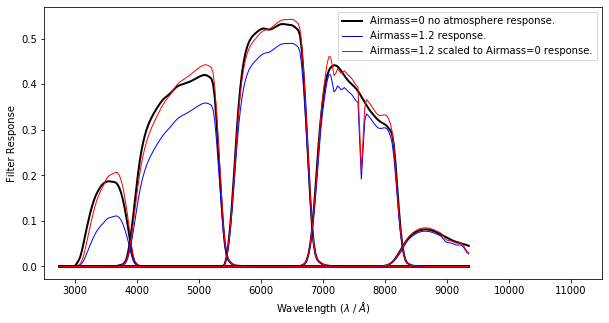

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


# filter response functions from Doi et al (2010)
# found http://classic.sdss.org/dr7/instruments/imager/index.html#filters
sdss_filters = 'Sources/utils/CFIS-cfg/SDSS_Photometry/'
# configuration path (SEx params, gim2d files, etc.)
sdss_cfg_path = 'Sources/utils/CFIS-cfg/SDSS_Photometry/'
# target redshift
redshift = 0.1
airmass=1.2

# wavelength list from SKIRT
wl_filename = sdss_cfg_path+'SDSS_gri3_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['u','g','r','i','z']

# useful constants / quantities
speed_of_light = 2.998e8 # [m/s]
speed_of_light = speed_of_light*1e10 # [Angstrom/s]

# wavelengths of datacube [microns] (expand by redshift factor)
wl = np.loadtxt(wl_filename).astype(float)*1e4*(1+redshift) # [Angstrom]
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

for band in bands:

    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,3]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=0 no atmosphere response.' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    # extinction values in column 4 assume an airmass of 1.0
    #plt.plot(filter_wl,filter_data[:,4])
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_air = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='blue',linewidth=1,linestyle='solid',
            label=('Airmass={} response.'.format(airmass) if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(sdss_filters+'{}.dat'.format(band))
    filter_wl = filter_data[:,0]
    kk = -2.5*np.log10(filter_data[:,4])
    correction = 10**(-0.4*(airmass*kk))
    filter_res = filter_data[:,3]*correction*norm_zeroair/norm_air
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    
    plt.plot(wl,filter_res,color='red',linewidth=1,linestyle='solid',
             label=('Airmass={} scaled to Airmass=0 response.'.format(airmass) if band is 'r' else None))
    
ax.legend()
ax.set_xlim(2500,11500)
    


## CFIS filters

### Particularities

The CFIS filter curves already incorporate an airmass of 1.25 and corresponding extinction. Consequently, I must use the extinction function $k(\lambda)$ to back-out an airmass=0 filter curve. This is shown below. Coloured lines correspond to airmass=0 filter curves and solid lines correspond to the default airmass=1.25. Notice, however, that $k(\lambda)$ is not sufficiently resolved that I can remove the strong atmospheric absorption feature in the $i$-band. Nonetheless, the effects on the other bands are removed nicely.

(2500, 11500)

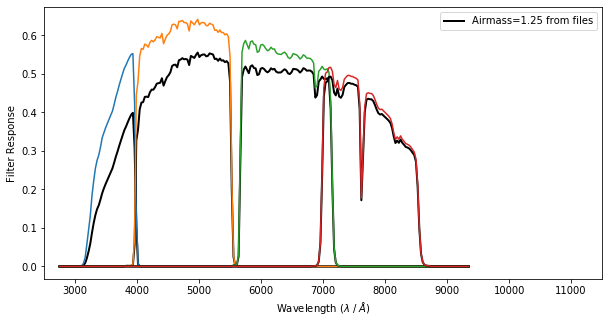

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt


# configuration path (SEx params, gim2d files, etc.)
cfis_cfg_path = 'Sources/utils/CFIS-cfg/CFIS_Photometry/'
# target redshift
redshift = 0.1
airmass=1.2

# wavelength list from SKIRT
wl_filename = cfis_cfg_path+'SKIRT_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['u','g','r','i']

# useful constants / quantities
speed_of_light = 2.998e8 # [m/s]
speed_of_light = speed_of_light*1e10 # [Angstrom/s]

# wavelengths of datacube [microns] (expand by redshift factor)
wl = np.loadtxt(wl_filename).astype(float)*1e4*(1+redshift) # [Angstrom]
# wavelength bin widths [Angstrom]
dwl = np.median(np.diff(wl)) # [Angstrom]

# set up figure
fig,ax = plt.subplots(figsize=(10,5))
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('Filter Response')

for band in bands:

    filter_data = np.loadtxt(cfis_cfg_path+'{}_CFIS.res'.format(band.capitalize()))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    norm_zeroair = np.trapz(filter_res,wl)
    plt.plot(wl,filter_res,color='black',linewidth=2,linestyle='solid',
            label=('Airmass=1.25 from files' if band is 'r' else None))
    
    # filter response function (w/ atmospheric effects but renormalized)
    filter_data = np.loadtxt(cfis_cfg_path+'{}_CFIS.res'.format(band.capitalize()))
    filter_wl = filter_data[:,0]
    filter_res = filter_data[:,1]
    filter_res = np.interp(xp=filter_wl,x=wl,fp=filter_res,left=0,right=0) # unitless
    # extinction file
    kkFile = cfis_cfg_path+'CFIS_extinction.txt'
    wl_kk,kk = np.loadtxt(kkFile,unpack=True)
    kk = np.interp(xp=wl_kk,x=wl,fp=kk,left=np.nanmax(kk),right=0)
    # 1.25 because CFIS response curves assume 1.25 airmass by default
    airmass=0.
    filter_res *= 10**(0.4*((1.25-airmass)*kk))
    plt.plot(wl,filter_res)

ax.legend()
ax.set_xlim(2500,11500)
    


### Comparison of $k(\lambda)$ from CFIS and SDSS

$k(\lambda)$ is measured seperately for CFIS and SDSS. Below, I inspect and compare those measurements. The black shows the SDSS extinction curve. The red shows CFIS.

Text(0, 0.5, '$k(\\lambda)$ [mag/airmass]')

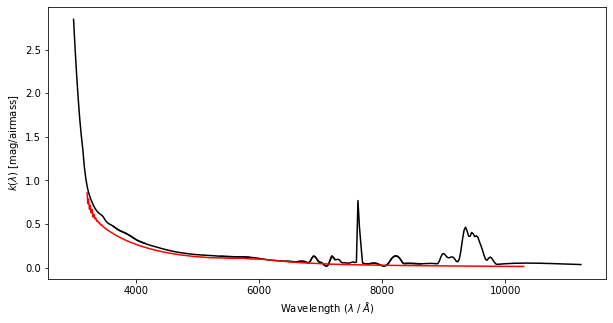

In [7]:
sdss_bands = ['u','g','r','i','z']
cfis_bands = ['U','G','R','I','Z']
cfis_path = '/Users/cbottrell/Project/RealSimCFIS/Sources/utils/CFIS-cfg/CFIS_Photometry/'
sdss_path = '/Users/cbottrell/Project/RealSimCFIS/Sources/utils/CFIS-cfg/SDSS_Photometry/'

fig,ax = plt.subplots(figsize=(10,5))

for band in sdss_bands:
    
    fileName = sdss_path+'{}.dat'.format(band)
    filterData = np.loadtxt(fileName)
    filter_wl, filter_res = filterData[:,0],filterData[:,4]
    ax.plot(filter_wl,-2.5*np.log10(filter_res),color='black')
    
fileName = cfis_path + 'CFIS_extinction.txt'
filter_wl,filter_res = np.loadtxt(fileName,unpack=True)
#filter_res = 10**(-0.4*(filter_res))
ax.plot(filter_wl,filter_res,color='red')
ax.set_xlabel(r'Wavelength ($\lambda$ / $\AA$)')
ax.set_ylabel('$k(\lambda)$ [mag/airmass]')

    

## Produce idealized synthetic CFIS images

Below I use a similar script to the one used for SDSS in the `RealSim` example notebook to produce CFIS images at a specific target redshift. I also test out the functionality of multiprocessing with the `SpecPhotCFIS` function. Very speedy.

In [1]:
#!/usr/bin/env python

import os,sys
from glob import glob
from SpecPhotCFIS import SpecPhotCFIS
import multiprocessing

# get cpu count
# SLURM_CPUS = int(os.environ['SLURM_JOB_CPUS_PER_NODE']) # for cluster
# get cpu count
SLURM_CPUS = 2

# base path to SKIRT datacubes
ifu_base_path = 'Inputs/Datacubes/'
# configuration path (SEx params, gim2d files, etc.)
cfis_cfg_path = 'Sources/utils/CFIS-cfg/CFIS_Photometry/'
# target redshift
redshift = 0.046

# list of SKIRT datacubes
ifuList = list(sorted(glob(ifu_base_path+'spec*.fits')))
# wavelength list from SKIRT
wl_filename = cfis_cfg_path+'SKIRT_wavelength_grid.dat'
# bands in which to produce photometry
bands = ['g','r','i']

if __name__ is '__main__':

    # produce argument list to send to function
    argList = []
    for ifuName in ifuList:
        _outputName = ifuName.replace(ifu_base_path,'Inputs/').replace('spec_','photo_{}_CFIS_')
        argList.append((ifuName,_outputName,wl_filename,cfis_cfg_path,redshift))
    argList = list(set(argList))

    # pool function application to argument list
    pool = multiprocessing.Pool(SLURM_CPUS)
    pool.starmap(SpecPhotCFIS, argList)
    pool.close()
    pool.join()


## Major adaptation to `ObsRealism.py`

Here I test the `ObsRealism.py` function for CFIS.

In [68]:
#!/bin/env python

import numpy as np
import os,sys,string,time
import scipy.interpolate
import scipy.ndimage
import warnings
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.cosmology import FlatLambdaCDM
import sep,vos

# RealSimCFIS base directory 
RSDIR = '/Users/cbottrell/Project/RealSimCFIS/'

def getInfo_SQL():
    '''Grab object and tile info from database.'''
    import pymysql
    cnf_path = '/Users/cbottrell/.mysql/lauca.cnf'
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell',
                         database='sdss',
                         read_default_file=cnf_path)
    c = db.cursor()
    dbcmd = ['SELECT objID,ra,decl,CFIS_tile',
             'FROM dr7_uberuber',
             'WHERE in_CFIS_May2019=1']
    c.execute(' '.join(dbcmd))
    data = np.asarray(c.fetchall())
    c.close()
    db.close()
    objIDs = data[:,0].astype(int)
    ras = data[:,1].astype(float)
    decs = data[:,2].astype(float)
    tiles = data[:,3]
    return objIDs,ras,decs,tiles

def getInfo_File():
    catName = RSDIR+'/Sources/Catalogues/CFIS-DR7_fieldInfo.npy'
    objIDs,ras,decs,tiles = np.load(catName)
    objIDs = data[0,:].astype(int)
    ras = data[1,:].astype(float)
    decs = data[2,:].astype(float)
    tiles = data[3,:]
    return objIDs,ras,decs,tiles


use_sql = False # default
if use_sql:
    objIDs,ras,decs,tiles = getInfo_SQL()
else:
    objIDs,ras,decs,tiles = getInfo_File()


    
    




[116.02070458 116.11330498 116.36624244 ... 199.83304484 199.9294709
 199.93094397]


In [ ]:
print(ras)